### NCEM

Both the runs above have been executed without Cell2Location, i.e. without Deconvolution
1. This script uses 10X Breast Cancer Spatial Data and Louvian Clusters.
2. This script is also run for simulated Breast Cancer data.

##### NCEM Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import ncem as nc
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import squidpy as sq
import pandas as pd
from anndata import AnnData
from itertools import combinations
import stlearn as st

from ncem.interpretation import InterpreterDeconvolution
from ncem.train import TrainModelLinearDeconvolution
from ncem.data import get_data_custom, customLoaderDeconvolution, customLoader
from ncem.interpretation import InterpreterInteraction
print(f"ncem=={nc.__version__}")

sc.settings.set_figure_params(dpi=80)
#import warnings
#warnings.filterwarnings("ignore")


2023-01-31 19:16:30.248800: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 19:16:30.437245: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/mpi/openmpi3-gnu8/3.1.4/lib:/opt/ohpc/pub/compiler/gcc/8.3.0/lib64
2023-01-31 19:16:30.437282: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-31 19:16:32.167733: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinf

ncem==0.1.4


### NCEM - Breast Cancer Data (Louvian Cluster)

In [7]:
## Read the Spatial data and pre-process to add lieden clustering information
data_dir = "/afm01/UQ/Q1851/Jon/Human_Breast_Cancer_Block_A_Section_1/"
adata_vis = st.Read10X(data_dir)
adata_vis.var_names_make_unique()
st.add.image(adata=adata_vis,
             imgpath=data_dir+"spatial/tissue_hires_nobg.png",
             library_id="V1_Breast_Cancer_Block_A_Section_1", visium=True)
lieden_cluster = pd.read_csv("/home/uqomulay/90days/stLearn_rebuttal/bc_leiden_cluster.csv",index_col=0)
adata_vis.obs = pd.concat([adata_vis.obs,lieden_cluster],axis=1)
adata_vis = adata_vis[adata_vis.obs.index.isin(lieden_cluster.index)]

adata = AnnData(X=adata_vis.to_df(),obs=adata_vis.obs)
adata.obs["cell_type"] = lieden_cluster["cell_type"]
adata.obs["cell_type"] = "A"+adata.obs["cell_type"].astype(str)
adata.obsm["spatial"] = adata_vis.obsm["spatial"]
adata.uns["spatial"] = adata_vis.uns["spatial"]
adata.write_h5ad("/afm01/UQ/Q1851/Jon/Human_Breast_Cancer_Block_A_Section_1/visium_hne_adata.h5ad")

/home/uqomulay/90days/.conda/envs/stlearn_rebuttal_SPA/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added tissue image to the object!


Loading data from raw files
registering celldata
collecting image-wise celldata
adding graph-level covariates


100%|██████████| 1/1 [00:00<00:00,  9.06it/s]

Loaded 1 images with complete data from 1 patients over 3789 cells with 33538 cell features and 11 distinct celltypes.


Mean of mean node degree per images across images: 6.000000
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 3789 cells out of 1 images from 1 patients.
Test dataset: 379 cells out of 1 images from 1 patients.
Training dataset: 3088 cells out of 1 images from 1 patients.
Validation dataset: 341 cells out of 1 images from 1 patients. 



100%|██████████| 378/378 [07:45<00:00,  1.23s/it]


using ols parameters.
calculating inv fim.


/home/uqomulay/.local/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


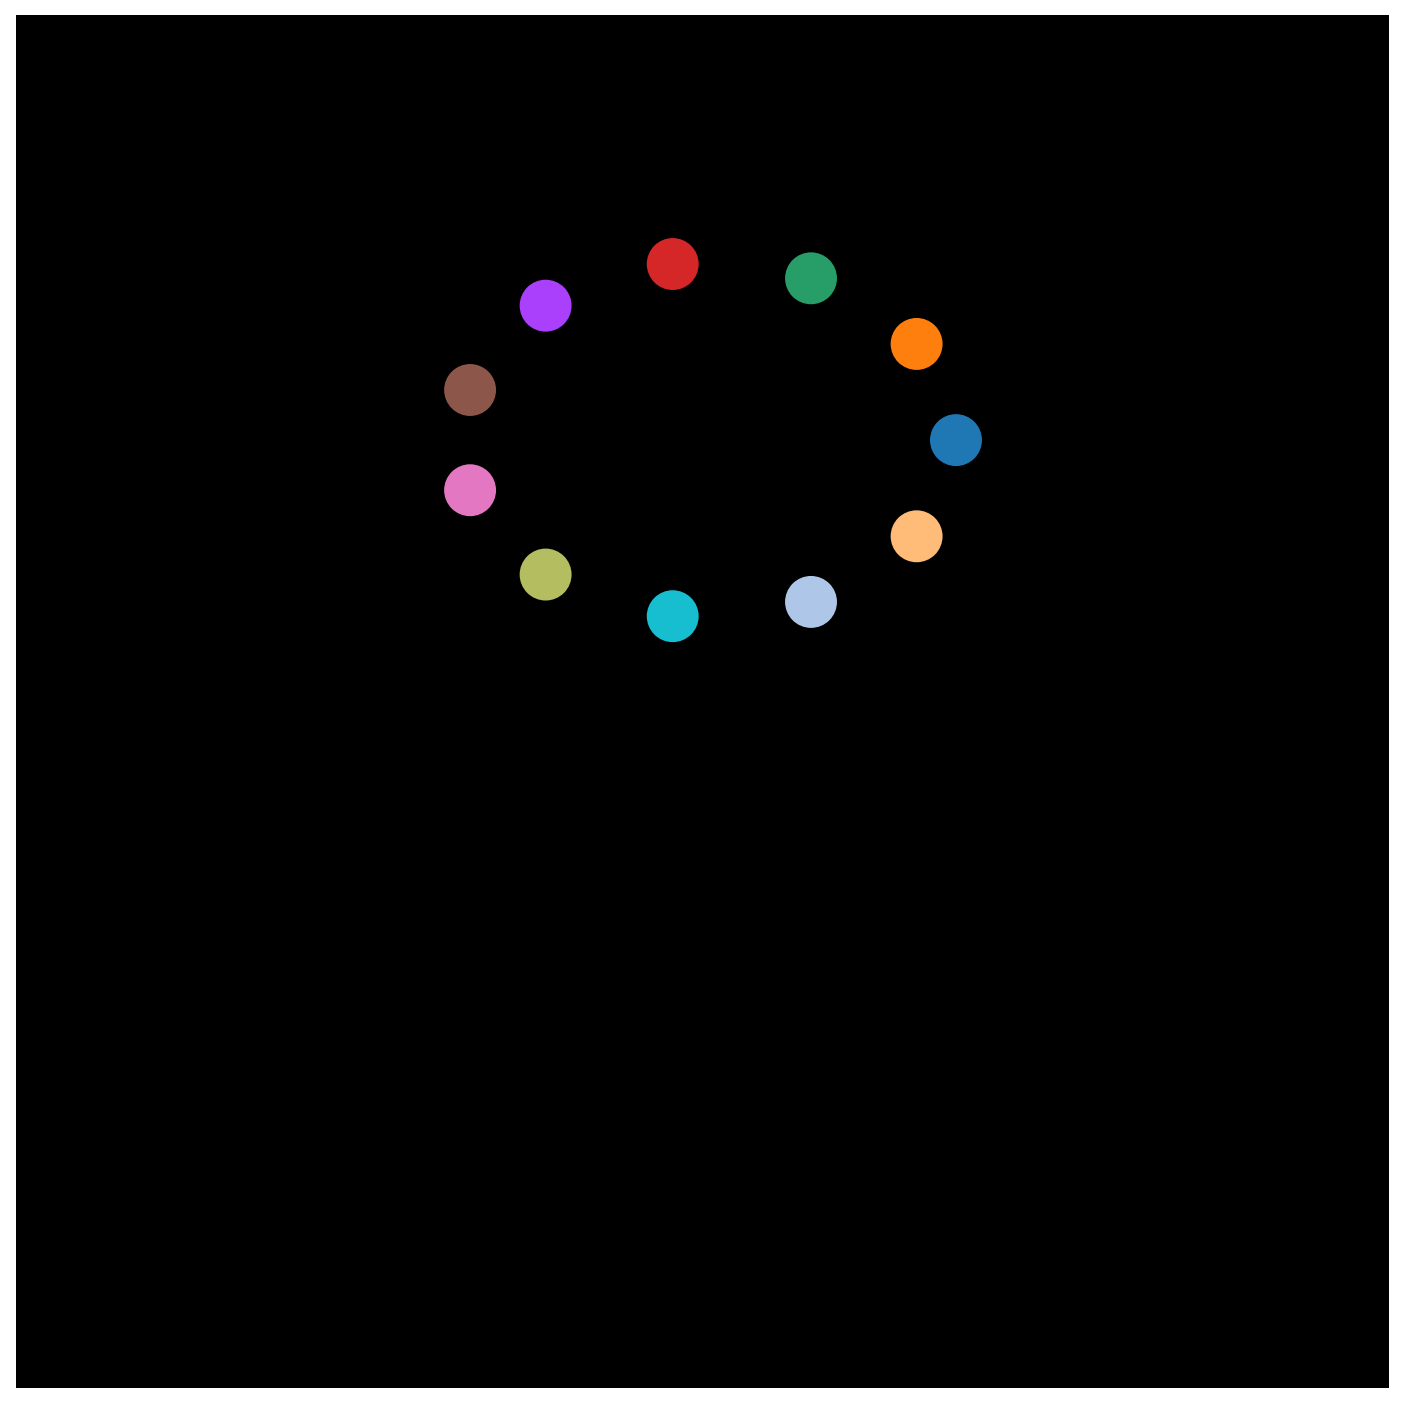

,sender,receiver,0,magnitude,de_genes,de_genes_abs
1,A0,A1,521,8.204712e+01,0.035356,521
2,A0,A10,338,9.407506e+01,0.022937,338
3,A0,A2,380,2.129142e+02,0.025787,380
4,A0,A3,998,2.443980e+02,0.067725,998
5,A0,A4,1366,3.000726e+02,0.092698,1366
...,...,...,...,...,...,...
115,A9,A4,12737,2.230005e-13,0.864346,12737
116,A9,A5,13039,1.398238e-13,0.884840,13039
117,A9,A6,0,0.000000e+00,0.000000,0
118,A9,A7,0,0.000000e+00,0.000000,0


In [10]:
## Set the parameters for NCEM
adata_vis2 = sc.read_h5ad("/afm01/UQ/Q1851/Jon/Human_Breast_Cancer_Block_A_Section_1/visium_hne_adata.h5ad")


log_transform = False
use_domain = True
scale_node_size=False
merge_node_types_predefined = True
covar_selection = []
output_layer='linear'
data_path = '/afm01/UQ/Q1851/Jon/Human_Breast_Cancer_Block_A_Section_1/'
data_set = 'real_breast_cancer'
feature_space_id = "standard"
cond_feature_space_id = "type"

## Run the interpretation for treating Spatial data as Single-cell data
interpreter = nc.interpretation.interpreter.InterpreterInteraction()
interpreter.get_data(data_origin="custom_real",
                    data_path=data_path,
                    radius=None,
                    node_label_space_id=cond_feature_space_id,
                    node_feature_space_id=feature_space_id,)
interpreter.undefined_node_types = None
interpreter.split_data_node(0.1, 0.1)
interpreter.n_eval_nodes_per_graph = 10
interpreter.cell_names = list(interpreter.data.celldata.uns['node_type_names'].values())
interpreter.get_sender_receiver_effects()

## Get the LR scores
cell_types = ['A0', 'A1', 'A10', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9']
LR_score_by_celltype = []
res = list(combinations(cell_types, 2))
for i in range(0,len(res)):
    df = interpreter.sender_receiver_values(receiver=res[i][0], sender=res[i][1])
    df["receiver_sender"] = [res[i][0]+"-"+res[i][1]]*len(df)
    LR_score_by_celltype.append(df)
for i in range(0,len(res)):
    df = interpreter.sender_receiver_values(receiver=res[i][1], sender=res[i][0])
    df["receiver_sender"] = [res[i][0]+"-"+res[i][1]]*len(df)
    LR_score_by_celltype.append(df)
for i in range(0,len(cell_types)):
    df = interpreter.sender_receiver_values(receiver=cell_types[i], sender=cell_types[i])
    df["receiver_sender"] = [cell_types[i]+"-"+cell_types[i]]*len(df)
    LR_score_by_celltype.append(df)
    
LR_score_by_celltype = pd.concat(LR_score_by_celltype)
LR_score_by_celltype

## type_coupling_analysis_circular
interpreter.type_coupling_analysis_circular(
    edge_attr='magnitude', 
    edge_width_scale=3.5,
    de_genes_threshold=24,
    figsize=(9,9),
    text_space=1.35
)

/home/uqomulay/.local/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


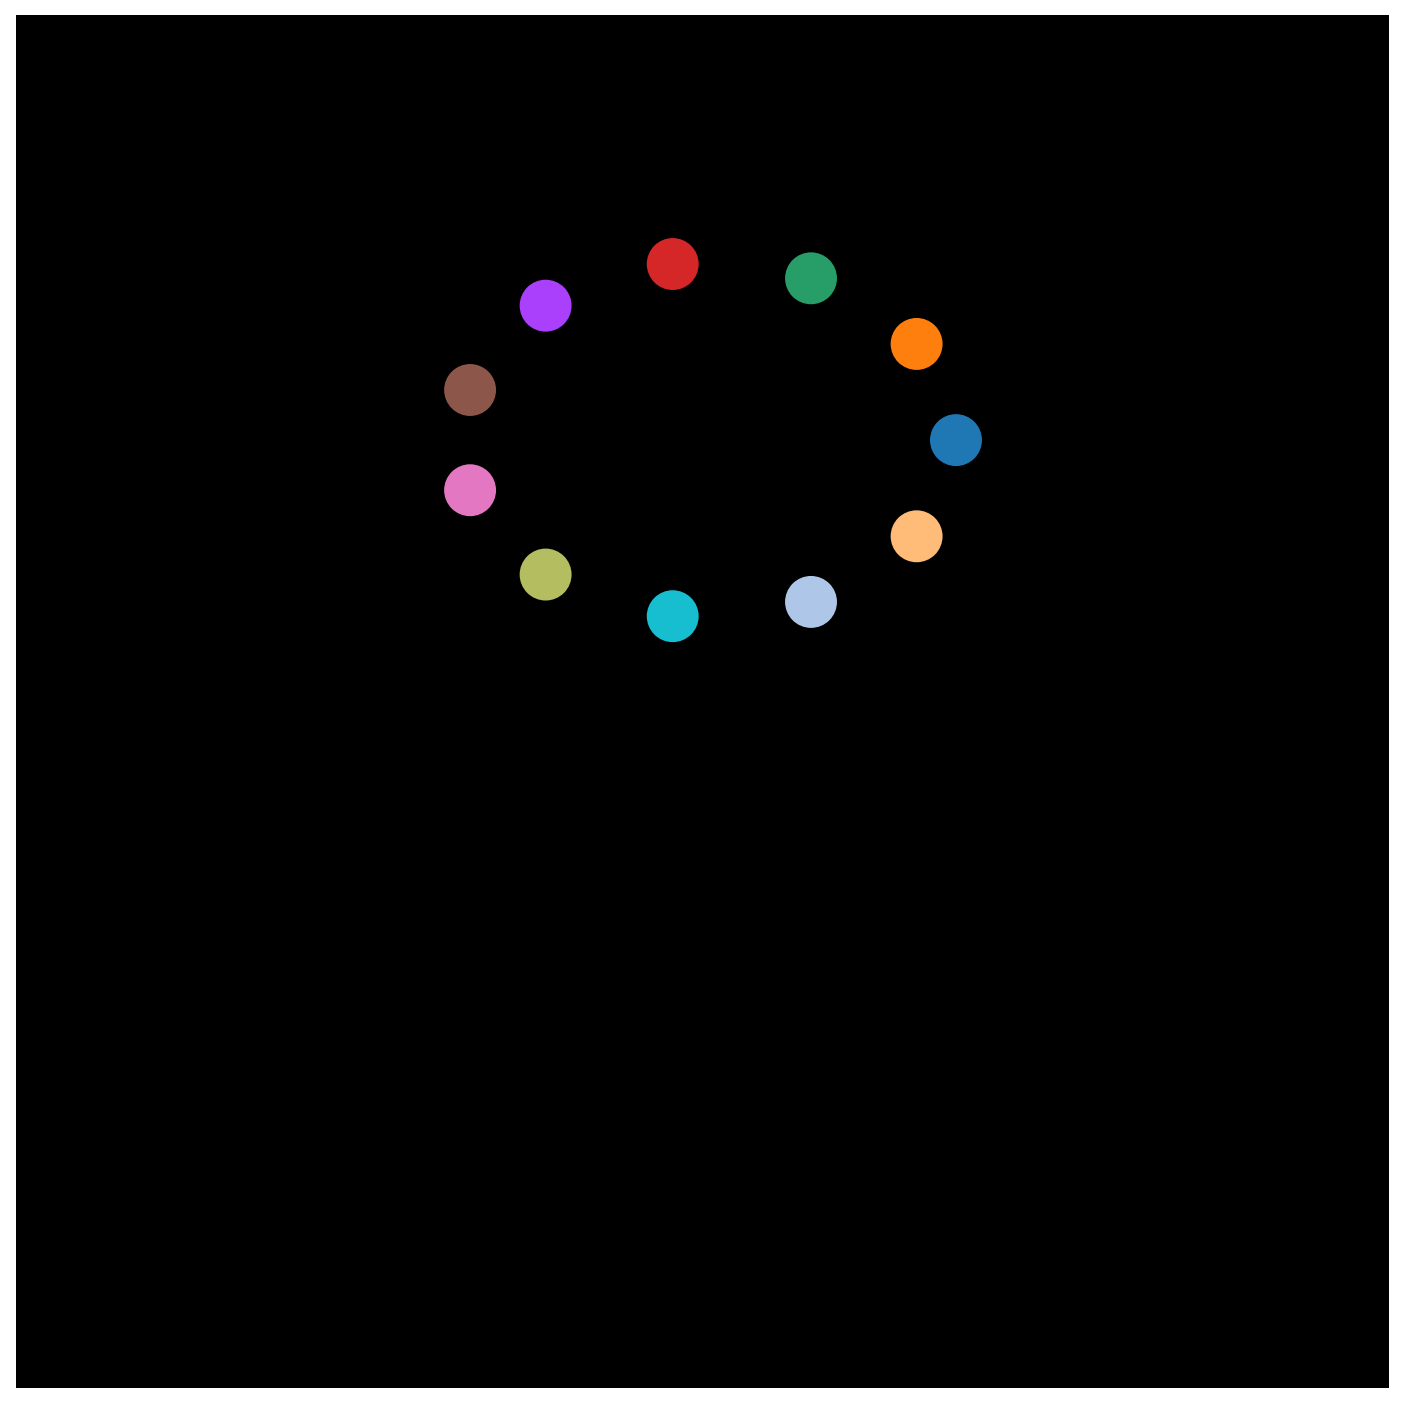

In [16]:
chord_plot = interpreter.type_coupling_analysis_circular(
    edge_attr='magnitude', 
    edge_width_scale=3.5,
    de_genes_threshold=24,
    figsize=(9,9),
    text_space=1.35
)
chord_plot.to_csv("/afm01/UQ/Q1851/Onkar/stLearn_rebuttal/Outputs/NCEM/Chordplot_Lieden_LR_score_by_celltype.csv")
LR_score_by_celltype.to_csv("/afm01/UQ/Q1851/Onkar/stLearn_rebuttal/Outputs/NCEM/Lieden_LR_score_by_celltype.csv")

### NCEM - Simulated Breast Cancer Data

Loading data from raw files
registering celldata
collecting image-wise celldata
adding graph-level covariates


100%|██████████| 1/1 [00:00<00:00, 18.98it/s]

Loaded 1 images with complete data from 1 patients over 1936 cells with 10335 cell features and 5 distinct celltypes.



2023-01-31 19:17:42.050193: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/mpi/openmpi3-gnu8/3.1.4/lib:/opt/ohpc/pub/compiler/gcc/8.3.0/lib64
2023-01-31 19:17:42.050255: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-31 19:17:42.050284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (delta074): /proc/driver/nvidia/version does not exist
2023-01-31 19:17:42.050745: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the app

Mean of mean node degree per images across images: 6.000000
Using split method: node. 
 Train-test-validation split is based on total number of nodes per patients over all images.

Excluded 0 cells with the following unannotated cell type: [None] 

Whole dataset: 1936 cells out of 1 images from 1 patients.
Test dataset: 194 cells out of 1 images from 1 patients.
Training dataset: 1578 cells out of 1 images from 1 patients.
Validation dataset: 174 cells out of 1 images from 1 patients. 



100%|██████████| 193/193 [00:41<00:00,  4.65it/s]


using ols parameters.
calculating inv fim.
         mean expression  pvalue  qvalue  fold change  -log 10 qvalue  \
A1BG           74.712540     NaN     NaN          0.0             NaN   
A1CF            0.191795     NaN     NaN          0.0             NaN   
A2M         24288.724609     NaN     NaN          0.0             NaN   
A2M-AS1       130.856262     NaN     NaN          0.0             NaN   
A2ML1           4.560781     NaN     NaN          0.0             NaN   
A2MP1           0.000000     NaN     NaN          0.0             NaN   
AACSP1          0.201287     NaN     NaN          0.0             NaN   
AADAC          57.918945     NaN     NaN          0.0             NaN   
AADACL2         3.685605     NaN     NaN          0.0             NaN   
AADAT          80.103668     NaN     NaN          0.0             NaN   

            receiver_sender  
A1BG     stroma-mesenchymal  
A1CF     stroma-mesenchymal  
A2M      stroma-mesenchymal  
A2M-AS1  stroma-mesenchymal  
A2M

/home/uqomulay/.local/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


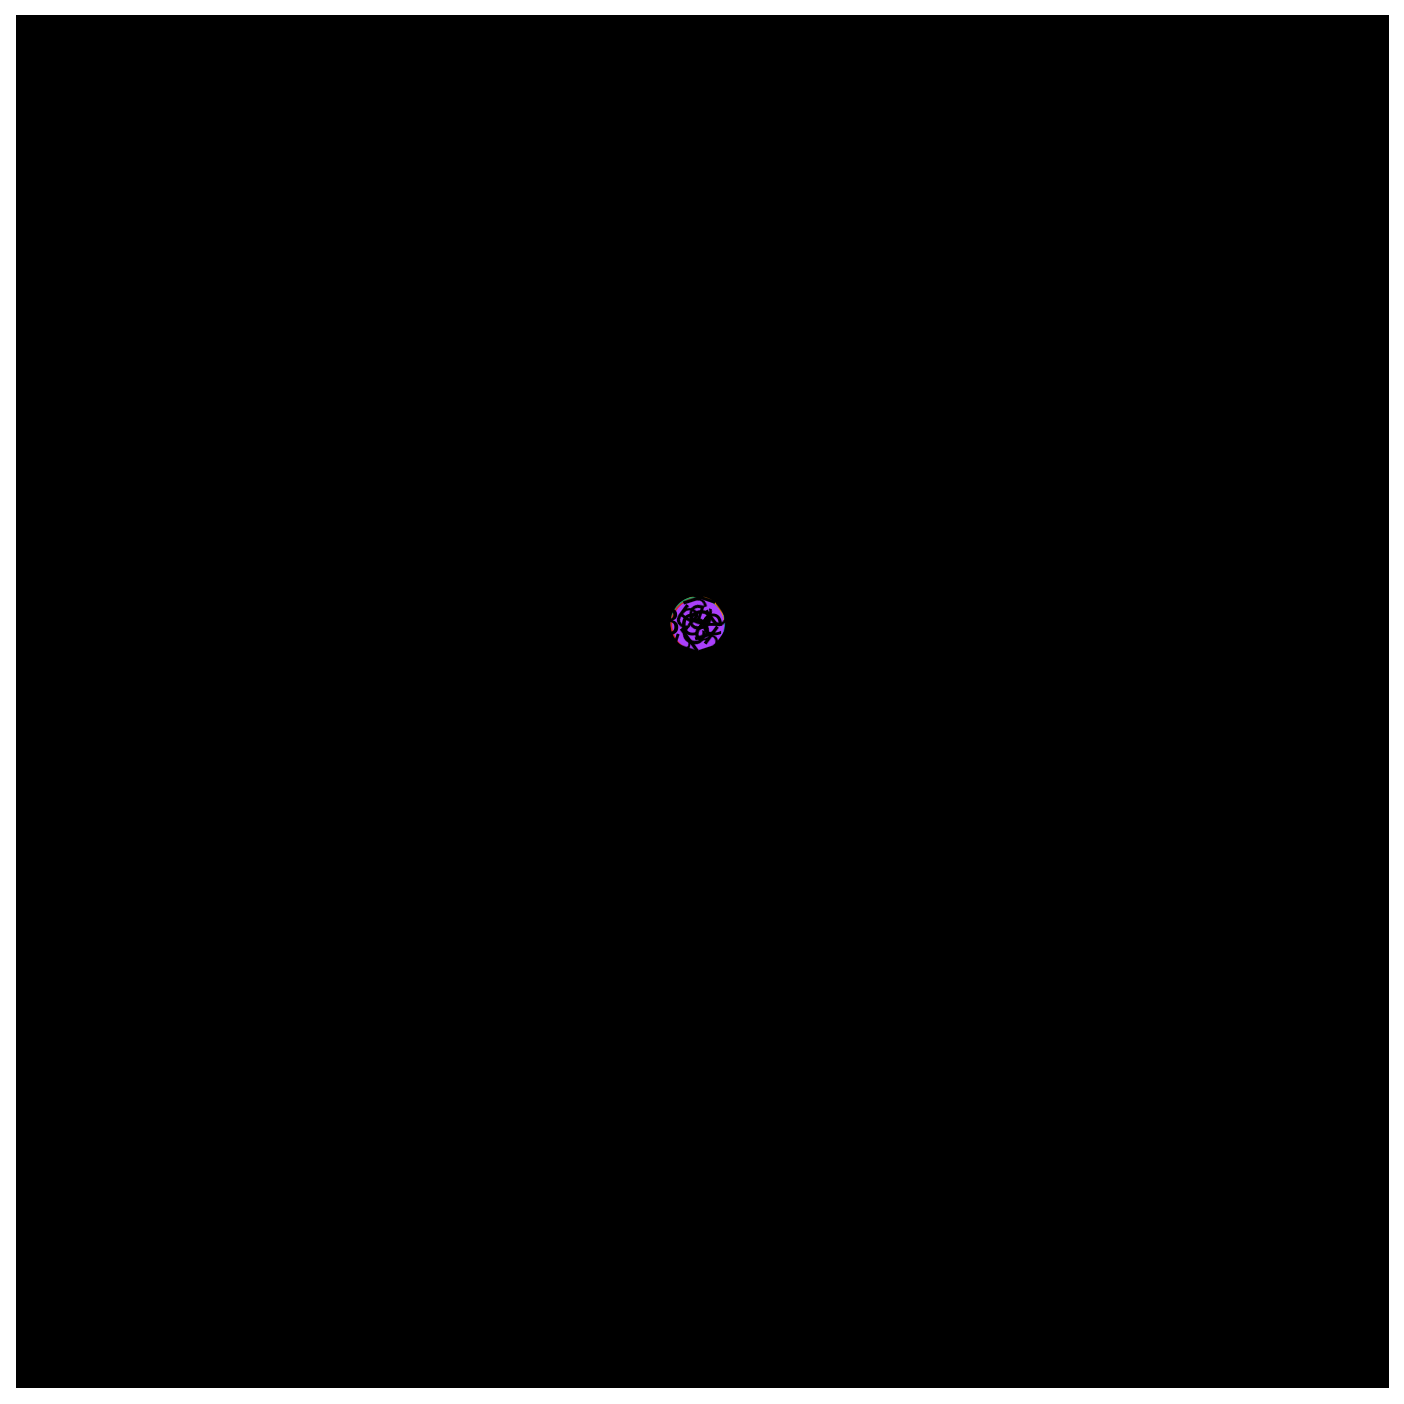

,sender,receiver,0,magnitude,de_genes,de_genes_abs
1,Bcell,Tcell,195,1.046182e+04,0.022126,195
2,Bcell,luminal_ar,165,1.127558e+04,0.018722,165
3,Bcell,mesenchymal,196,7.144889e+04,0.022240,196
4,Bcell,stroma,215,6.996524e+03,0.024396,215
5,Tcell,Bcell,197,1.159678e+04,0.022353,197
7,Tcell,luminal_ar,170,1.196359e+04,0.019290,170
8,Tcell,mesenchymal,0,0.000000e+00,0.000000,0
9,Tcell,stroma,199,9.792332e+03,0.022580,199
10,luminal_ar,Bcell,950,2.139128e+04,0.107795,950
11,luminal_ar,Tcell,982,2.728627e+04,0.111426,982


In [2]:
## Read the Spatial data
adata_vis = sc.read_h5ad("/afm01/UQ/Q1851/Brad/simulation/spatialsim_v2.h5ad")

## Set the parameters for NCEM
log_transform = False
use_domain = True
scale_node_size=False
merge_node_types_predefined = True
covar_selection = []
output_layer='linear'
data_path = '/afm01/UQ/Q1851/Brad/simulation/'
data_set = 'spatialsim_v2'
feature_space_id = "standard"
cond_feature_space_id = "type"

## Run the interpretation for treating Spatial data as Single-cell data
interpreter_sim = nc.interpretation.interpreter.InterpreterInteraction()
interpreter_sim.get_data(data_origin="custom_simulated",
                    data_path=data_path,
                    radius=None,
                    node_label_space_id=cond_feature_space_id,
                    node_feature_space_id=feature_space_id,)

interpreter_sim.split_data_node(0.1, 0.1)
interpreter_sim.n_eval_nodes_per_graph = 10
interpreter_sim.cell_names = list(interpreter_sim.data.celldata.uns['node_type_names'].values())
interpreter_sim.get_sender_receiver_effects()

## Get the LR scores
cell_types = ["stroma", "mesenchymal","Tcell", "Bcell","luminal_ar"]
LR_score_by_celltype = []
res = list(combinations(cell_types, 2))
for i in range(0,len(res)):
    df = interpreter_sim.sender_receiver_values(receiver=res[i][0], sender=res[i][1])
    df["receiver_sender"] = [res[i][0]+"-"+res[i][1]]*len(df)
    LR_score_by_celltype.append(df)
for i in range(0,len(res)):
    df = interpreter_sim.sender_receiver_values(receiver=res[i][1], sender=res[i][0])
    df["receiver_sender"] = [res[i][0]+"-"+res[i][1]]*len(df)
    LR_score_by_celltype.append(df)
for i in range(0,len(cell_types)):
    df = interpreter_sim.sender_receiver_values(receiver=cell_types[i], sender=cell_types[i])
    df["receiver_sender"] = [cell_types[i]+"-"+cell_types[i]]*len(df)
    LR_score_by_celltype.append(df)
    
LR_score_by_celltype = pd.concat(LR_score_by_celltype)
print(LR_score_by_celltype.head(10))

interpreter_sim.type_coupling_analysis_circular(
    edge_attr='magnitude', 
    edge_width_scale=3.5,
    de_genes_threshold=24,
    figsize=(9,9),
    text_space=1.35
)


/home/uqomulay/.local/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


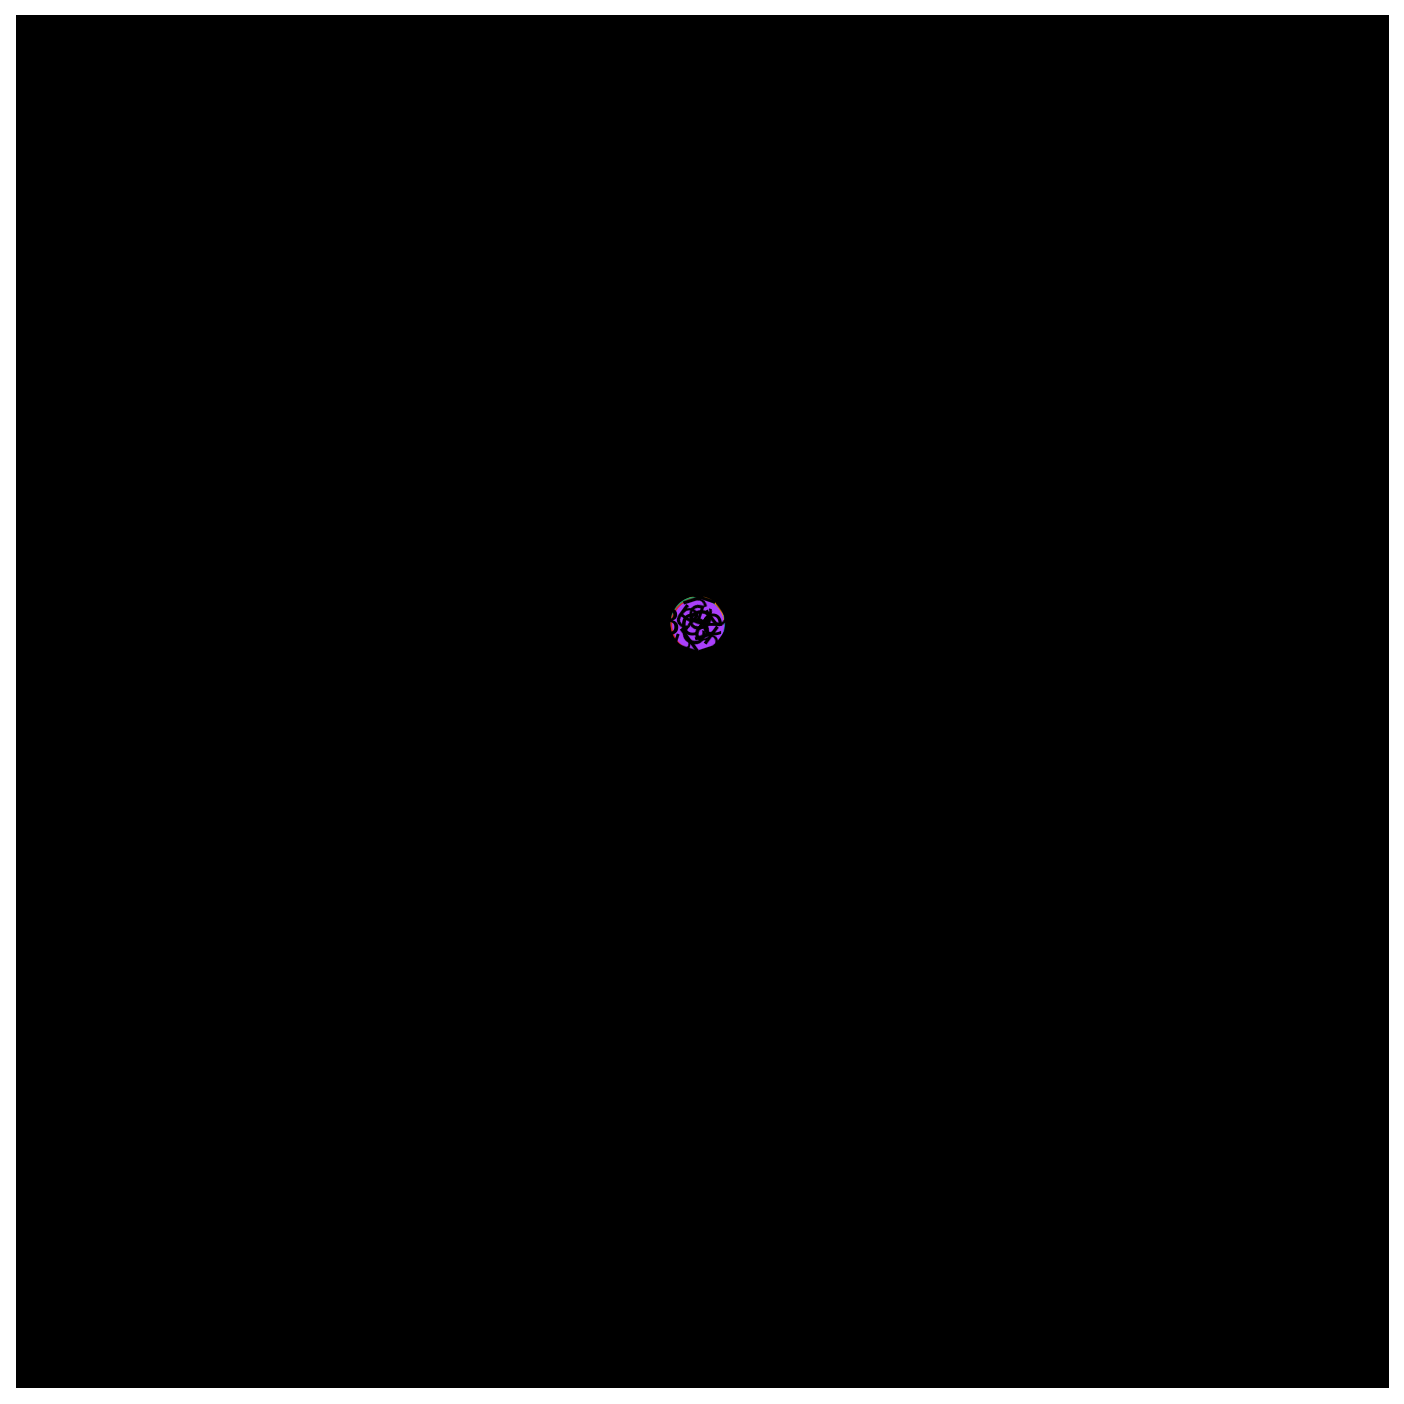

In [3]:
chord_plot = interpreter_sim.type_coupling_analysis_circular(
    edge_attr='magnitude', 
    edge_width_scale=3.5,
    de_genes_threshold=24,
    figsize=(9,9),
    text_space=1.35
)
chord_plot.to_csv("/afm01/UQ/Q1851/Onkar/stLearn_rebuttal/Outputs/NCEM/Chordplot_simulated_LR_score_by_celltype.csv")
#LR_score_by_celltype.to_csv("/afm01/UQ/Q1851/Onkar/stLearn_rebuttal/Outputs/NCEM/simulated_LR_score_by_celltype.csv")